## 10.2. Attention Pooling: Nadaraya-Watson Kernel Regression
查询（自主提示）和键（非自主提示）之间的交互产生了「注意力池化」，从而有选择性地聚合了值（感官输入）以产生输出。

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn

npx.set_np()

### 10.2.1. Generating the Dataset
人工数据集：
$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,\epsilon\sim\mathcal{N}(0,0.5)$$

In [2]:
f=lambda x: 2 * np.sin(x) + x**0.8
n_train = 50  # No. of training examples
x_train = np.sort(np.random.rand(n_train) * 5)  # Training inputs
y_train = f(x_train) + np.random.normal(0.0, 0.5,(n_train,))  # Training outputs

x_test = np.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples

n_test = len(x_test)  # No. of testing examples
x_train[:10],y_train[:10],x_test[:10],y_truth[:10]

(array([0.101092  , 0.2835649 , 0.35518026, 0.43564647, 0.59137213,
        0.70175385, 1.3632815 , 1.487673  , 1.6869808 , 1.8412077 ]),
 array([1.2770946, 1.4610012, 0.5589924, 1.4184881, 1.7988044, 1.5588262,
        1.9847035, 2.9793072, 3.2101474, 3.162818 ]),
 array([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
        0.5       , 0.6       , 0.7       , 0.8       , 0.90000004]),
 array([0.        , 0.35815614, 0.6732846 , 0.97271836, 1.2592864 ,
        1.5332003 , 1.7938248 , 2.040194  , 2.2712238 , 2.48582   ]))

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### 10.2.2. Average Pooling
使用平均池化来计算所有训练输出的平均值：
$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

(array(2.1768749),
 array([2.1768749, 2.1768749, 2.1768749, 2.1768749, 2.1768749]),
 (50,))

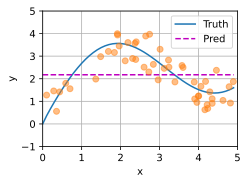

In [4]:
y_hat = y_train.mean().repeat(n_test)
plot_kernel_reg(y_hat)
y_train.mean(), y_hat[:5], y_hat.shape

### 10.2.3. Nonparametric Attention Pooling
使用 Nadaraya-Watson 核回归，核为 $K(u)=\frac1{\sqrt{2\pi}}\exp(-\frac{u^2}2)$，根据输入的位置对输出进行权衡：
$$
\begin{aligned}
f(x) &= \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i\\
        &=\sum_{i=1}^n\alpha(x,x_i)y_i\\
        &=\sum_{i=1}^n\frac{\exp(-\frac12(x-x_i)^2)}{\sum_{j=1}^n\exp(-\frac12(x-x_j)^2)}y_i\\
        &=\sum_{i=1}^n\mathrm{Softmax}(-\frac12(x-x_i)^2)y_i
\end{aligned}        
$$

((50, 50),
 (50, 50),
 (50,),
 array([[0. , 0. , 0. , 0. , 0. ],
        [0.1, 0.1, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.2, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.3],
        [0.4, 0.4, 0.4, 0.4, 0.4]]),
 array([[0.12988779, 0.12540847, 0.12257268, 0.11873413, 0.10960907],
        [0.12047197, 0.11845933, 0.11661282, 0.11387353, 0.10677186],
        [0.1110982 , 0.11125383, 0.11030678, 0.10858586, 0.10341187],
        [0.10182264, 0.10384295, 0.10369898, 0.10290588, 0.09954063],
        [0.09270795, 0.09628847, 0.09684607, 0.09688181, 0.09518435]]))

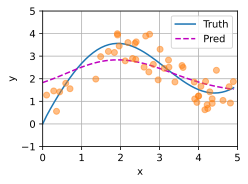

In [5]:
# X_repeat 的形状: (n_test, n_train), 用于批量计算 $f(x)$，而不是一个个计算
# 每一行都包含着相同的预测输入（例如：同样的查询）
X_repeat = x_test.repeat(n_train).reshape((-1, n_train))
# x_test 包含的是查询；x_train 包含的是键；y_train 包含的是值。
# attention_weights 的形状：(n_test, n_train), 
# 每一行包含的是在给定的每个键 (x_train) 对应的值 (y_train) 之间分配的注意力权重
# 用于计算查询 (x_test) 对应的值 (y_hat) 的输出
# 注：输入的查询受所有的键和当前位置的值的影响，同样的查询输出不同的值
attention_weights = npx.softmax(-(X_repeat - x_train) ** 2 / 2)
# y_hat 的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = np.dot(attention_weights, y_train)
plot_kernel_reg(y_hat)
X_repeat.shape, attention_weights.shape, y_hat.shape, X_repeat[:5,:5], attention_weights[:5,:5]

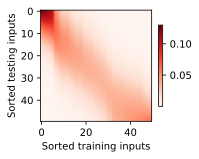

In [6]:
d2l.show_heatmaps(np.expand_dims(np.expand_dims(attention_weights, 0), 0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

### 10.2.4. Parametric Attention Pooling
-   非参数 Nadaraya-Watson 核回归具有 *一致性* 的好处：如果有足够的数据，此模型会收敛到最佳解决方案。
-   参数化注意力池化：对非参数模型加入参数

$$
\begin{aligned}
f(x) &= \sum_{i=1}^n \alpha(x, x_i)y_i  \\
    &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_i)w)^2\right)} y_i \\
    &= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.
\end{aligned}
$$

#### 10.2.4.1. Batch Matrix Multiplication
假设第一个小批量包含 $n$ 个矩阵 $\mathbf{X}_1,\ldots, \mathbf{X}_n$，形状为 $a\times b$，第二个小批量包含 $n$ 个矩阵 $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，形状为 $b\times c$。它们的批量矩阵乘法得出 $n$ 个矩阵 $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，形状为 $a\times c$。因此，假定两个张量的形状 $(n,a,b)$ 和 $(n,b,c)$ ，它们的批量矩阵乘法输出的形状为 $(n,a,c)$。

In [7]:
X=np.ones((2,1,4))
Y=np.ones((2,4,6))
npx.batch_dot(X,Y).shape, np.expand_dims(X,1).shape, np.expand_dims(Y,-1).shape

((2, 1, 6), (2, 1, 1, 4), (2, 4, 6, 1))

In [8]:
weights=np.ones((2,10))*0.1
values=np.arange(20).reshape((2,10))

In [9]:
weights_matrix=weights
values_matrix=values.T
np.dot(weights_matrix,values_matrix),weights_matrix.shape, values_matrix.shape

(array([[ 4.5, 14.5],
        [ 4.5, 14.5]]),
 (2, 10),
 (10, 2))

In [10]:
weights_matrix=np.expand_dims(weights,1)    # 1     表示从第一维开始扩展
values_matrix=np.expand_dims(values,-1)     # -1    表示从倒数第一维开始扩展
npx.batch_dot(weights_matrix,values_matrix),weights_matrix.shape,values_matrix.shape

(array([[[ 4.5     ]],
 
        [[14.500001]]]),
 (2, 1, 10),
 (2, 10, 1))

In [11]:
# 10.2.4.2. Defining the Model
class NWKernelRegression(nn.Block):
    def __init__(self, **kwargs):
        super(NWKernelRegression, self).__init__(**kwargs)
        self.attention_weights = None
        self.w = self.params.get('w', shape=(1,))

    def forward(self, queries, keys, values):
        # 'queries' 的形状: (查询的个数，“键－值”对的个数)
        queries = queries.repeat(keys.shape[1]).reshape((-1, keys.shape[1]))
        # 'attention_weights' 的形状: (查询的个数，“键－值”对的个数)
        self.attention_weights = npx.softmax(-((queries - keys) * self.w.data()) ** 2 / 2)
        # 'values' 的形状: (查询的个数，“键－值”对的个数)
        return npx.batch_dot(np.expand_dims(self.attention_weights, 1), np.expand_dims(values, -1)).reshape(-1)

In [12]:
# 10.2.4.3. Training
X_tile = np.tile(x_train, (n_train, 1))
Y_tile = np.tile(y_train, (n_train, 1))
keys = X_tile[(1 - np.eye(n_train)).astype('bool')].reshape((n_train, -1))
values = Y_tile[(1 - np.eye(n_train)).astype('bool')].reshape((n_train, -1))
X_tile.shape,Y_tile.shape,keys.shape,values.shape, keys[:5,:5], values[:5,:5]

((50, 50),
 (50, 50),
 (50, 49),
 (50, 49),
 array([[0.2835649 , 0.35518026, 0.43564647, 0.59137213, 0.70175385],
        [0.101092  , 0.35518026, 0.43564647, 0.59137213, 0.70175385],
        [0.101092  , 0.2835649 , 0.43564647, 0.59137213, 0.70175385],
        [0.101092  , 0.2835649 , 0.35518026, 0.59137213, 0.70175385],
        [0.101092  , 0.2835649 , 0.35518026, 0.43564647, 0.70175385]]),
 array([[1.4610012, 0.5589924, 1.4184881, 1.7988044, 1.5588262],
        [1.2770946, 0.5589924, 1.4184881, 1.7988044, 1.5588262],
        [1.2770946, 1.4610012, 1.4184881, 1.7988044, 1.5588262],
        [1.2770946, 1.4610012, 0.5589924, 1.7988044, 1.5588262],
        [1.2770946, 1.4610012, 0.5589924, 1.4184881, 1.5588262]]))

epoch 50, loss7.450143


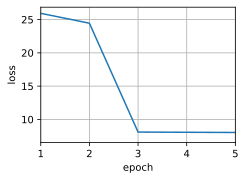

In [13]:
net = NWKernelRegression()
net.initialize()
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])
for epoch in range(50):
    with autograd.record():
        l = loss(net(x_train, keys, values), y_train)
    l.backward()
    trainer.step(1)
    animator.add(epoch + 1, float(l.sum()))
print(f'epoch {epoch + 1}, loss{float(l.sum()):.6f}')

(50,)

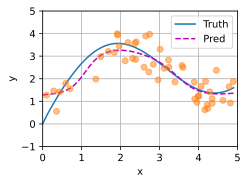

In [14]:
keys = np.tile(x_train, (n_test, 1))
values = np.tile(y_train, (n_test, 1))
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)
x_test.shape

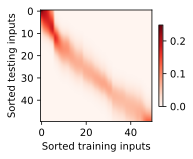

In [15]:
d2l.show_heatmaps(np.expand_dims(np.expand_dims(net.attention_weights, 0), 0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')